In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [12]:
# Load the dataset
df = pd.read_csv('../ready_data/merged_marwis.csv')
# Rename time dimension to "ds" and target variable to "y". This is COMPULSORY
df.rename({"timestamp": "ds",
           "Friction": "y"}, axis=1, inplace=True, copy=False)
df["ds"] = pd.to_datetime(df["ds"])
df['ds'] = df['ds'].dt.tz_localize(None)

df

,ds,Amb_T,y,Dew_Point_T,RH_at_Road_T,Water_Film_mm,Ice_Percentage,Road_Condition,Water_Film_Surface_mm,Road_Surface_Temperature
0,2023-12-01 06:00:00,7.542445,0.770759,0.0,85.157728,0.291341,0.000000,2.000000,0.100736,6.070967
1,2023-12-01 06:05:00,6.358008,0.627356,0.0,94.090596,0.307111,41.559838,2.855705,0.108008,1.225372
2,2023-12-01 06:10:00,1.043127,0.735368,0.0,100.000000,0.110350,36.588811,2.909091,0.043079,-2.701785
3,2023-12-01 06:15:00,1.000389,0.533147,0.0,100.000000,0.341481,69.512639,3.000000,0.120704,-2.368484
4,2023-12-01 06:20:00,1.000971,0.656794,0.0,100.000000,0.195085,53.043867,2.809365,0.070209,-2.343937
...,...,...,...,...,...,...,...,...,...,...
7617,2024-02-29 13:05:00,12.465430,0.812769,0.0,62.248380,0.020946,0.000000,0.000000,0.013573,15.102599
7618,2024-02-29 13:10:00,13.078210,0.813238,0.0,63.752008,0.019117,0.000000,0.000000,0.012682,15.284287
7619,2024-02-29 13:15:00,13.555827,0.813537,0.0,64.891077,0.017985,0.000000,0.000000,0.012114,15.431717
7620,2024-02-29 13:20:00,13.936328,0.809958,0.0,65.357731,0.042180,0.000000,0.288591,0.019243,15.438219


In [14]:
# Take a sample from dataset to cut off edges where friction is almost 0.8 every time
df["cap"] = 0.8

In [15]:
# Split the data to train and test
cutoff = int(len(df) * 0.8)

# train data
X_train = df[0:cutoff]
# test data 
X_test = df[cutoff:]

In [16]:
df.columns

Index(['ds', 'Amb_T', 'y', 'Dew_Point_T', 'RH_at_Road_T', 'Water_Film_mm',
       'Ice_Percentage', 'Road_Condition', 'Water_Film_Surface_mm',
       'Road_Surface_Temperature', 'cap'],
      dtype='object')

In [17]:
# Initialaze forecaster and scale values
model = Prophet(growth="logistic", scaling="minmax")
# Add regressors for multivariativity. Add a new regressor for each variable in dataset
model.add_regressor("Amb_T", standardize=False)
model.add_regressor("Dew_Point_T", standardize=False)
model.add_regressor("RH_at_Road_T", standardize=False)
model.add_regressor("Water_Film_mm", standardize=False)
model.add_regressor("Ice_Percentage", standardize=False)
model.add_regressor("Road_Condition", standardize=False)
model.add_regressor("Water_Film_Surface_mm", standardize=False)
model.add_regressor("Road_Surface_Temperature", standardize=False)

# Fit the model
model.fit(X_train)

15:02:20 - cmdstanpy - INFO - Chain [1] start processing
15:02:23 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Delete y variable from dataset
X_train2 = X_train.drop("y",axis=1)
X_test2 = X_test.drop("y", axis=1)

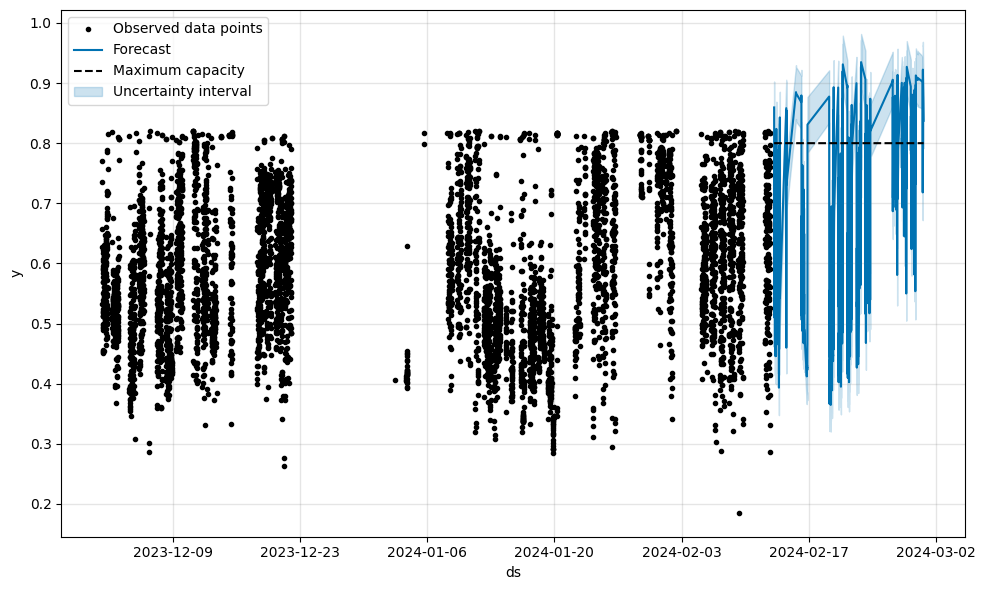

In [19]:
# Make a forecast for unseen X_test data and plot forecast
fcst = model.predict(X_test2)
fig = model.plot(fcst, include_legend=True)

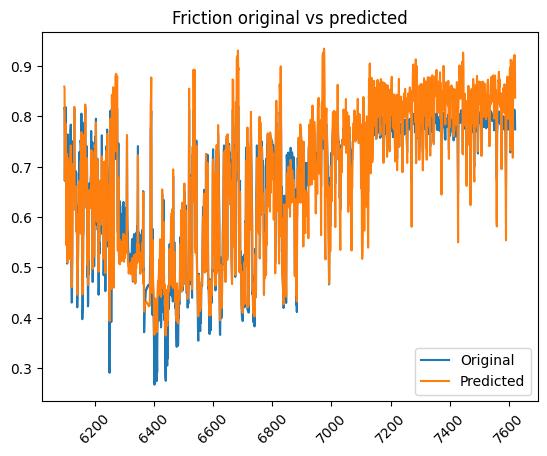

In [20]:
plt.title('Friction original vs predicted')
plt.plot(X_test.index, X_test.y, label="Original")
plt.plot(X_test.index, fcst.yhat, label="Predicted")
plt.xticks(rotation=45)
plt.legend()


In [21]:
# Test a forecast for X_train data
forecast1_train = model.predict(X_train2)
forecast1_train


,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,Amb_T,Amb_T_lower,Amb_T_upper,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-12-01 06:00:00,0.797590,0.8,0.746041,0.836149,0.797590,0.797590,0.007690,0.007690,0.007690,...,-0.008973,-0.008973,-0.008973,0.006763,0.006763,0.006763,0.0,0.0,0.0,0.793429
1,2023-12-01 06:05:00,0.797590,0.8,0.590685,0.683177,0.797590,0.797590,0.006482,0.006482,0.006482,...,-0.164112,-0.164112,-0.164112,0.006695,0.006695,0.006695,0.0,0.0,0.0,0.638642
2,2023-12-01 06:10:00,0.797590,0.8,0.669093,0.763383,0.797590,0.797590,0.001064,0.001064,0.001064,...,-0.089053,-0.089053,-0.089053,0.006625,0.006625,0.006625,0.0,0.0,0.0,0.714035
3,2023-12-01 06:15:00,0.797590,0.8,0.472223,0.563643,0.797590,0.797590,0.001020,0.001020,0.001020,...,-0.287510,-0.287510,-0.287510,0.006556,0.006556,0.006556,0.0,0.0,0.0,0.515892
4,2023-12-01 06:20:00,0.797591,0.8,0.583357,0.673735,0.797591,0.797591,0.001021,0.001021,0.001021,...,-0.176938,-0.176938,-0.176938,0.006485,0.006485,0.006485,0.0,0.0,0.0,0.626758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6092,2024-02-12 17:25:00,0.799602,0.8,0.391204,0.476965,0.799602,0.799602,-0.008221,-0.008221,-0.008221,...,-0.368228,-0.368228,-0.368228,-0.002983,-0.002983,-0.002983,0.0,0.0,0.0,0.435509
6093,2024-02-12 18:25:00,0.799602,0.8,0.374865,0.469057,0.799602,0.799602,-0.006213,-0.006213,-0.006213,...,-0.376942,-0.376942,-0.376942,-0.003136,-0.003136,-0.003136,0.0,0.0,0.0,0.422370
6094,2024-02-12 18:30:00,0.799602,0.8,0.775997,0.870609,0.799602,0.799602,-0.000848,-0.000848,-0.000848,...,0.025023,0.025023,0.025023,-0.003145,-0.003145,-0.003145,0.0,0.0,0.0,0.823926
6095,2024-02-12 18:35:00,0.799602,0.8,0.758528,0.844798,0.799602,0.799602,0.001634,0.001634,0.001634,...,0.003433,0.003433,0.003433,-0.003154,-0.003154,-0.003154,0.0,0.0,0.0,0.801932


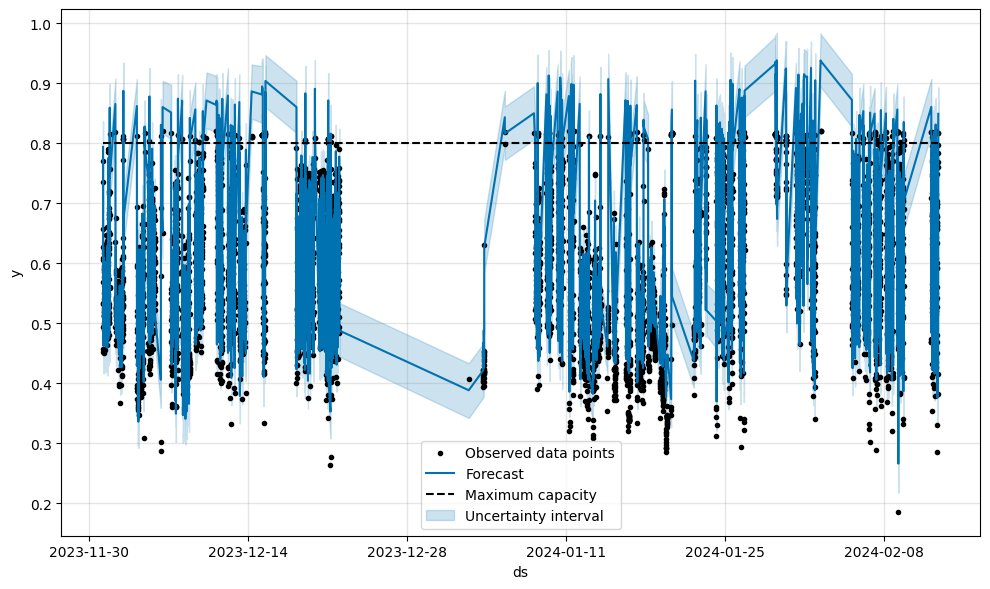

In [22]:
# Plot test forecast
fig = model.plot(forecast1_train, include_legend=True)

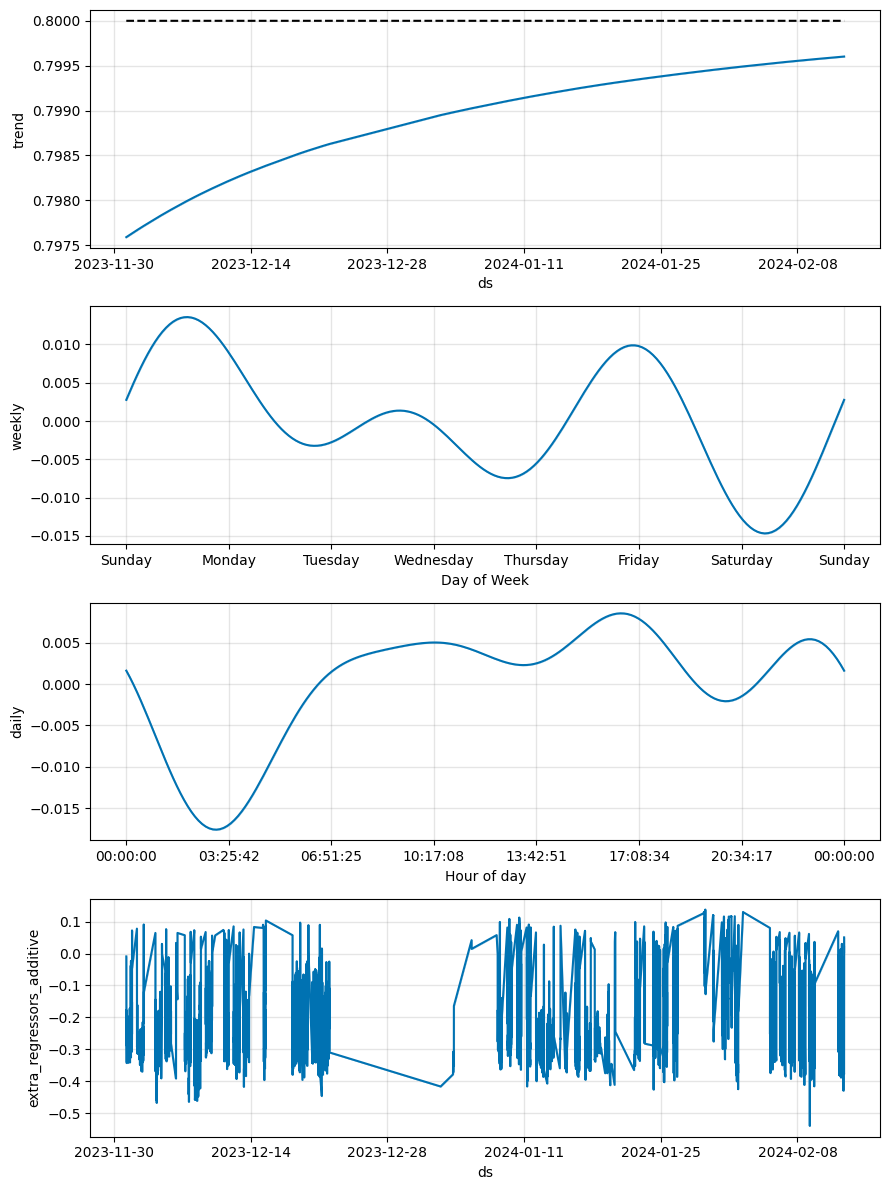

In [23]:
# plot components of test forecast
fig = model.plot_components(forecast1_train)


In [24]:
# Run cross validation and save results into DF for further usage
# parameters:
# horizon: string with pd.Timedelta compatible style, e.g., '5 days',

# period: string with pd.Timedelta compatible style. Simulated forecast will
# be done at every this period. If not provided, 0.5 * horizon is used.

# initial: string with pd.Timedelta compatible style. The first training
# period will include at least this much data. If not provided,
# 3 * horizon is used.

# cutoffs: list of pd.Timestamp specifying cutoffs to be used during
# cross validation. If not provided, they are generated as described
# above.

# parallel : {None, 'processes', 'threads', 'dask', object}

df_cv2 = cross_validation(model, horizon='2 days',parallel='processes')


15:02:37 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:39 - cmdstanpy - INFO - Chain [1] done processing
15:02:39 - cmdstanpy - INFO - Chain [1] done processing
15:02:39 - cmdstanpy - INFO - Chain [1] done processing
15:02:39 - cmdstanpy - INFO - Chain [1] done processing
15:02:39 - cmdstanpy - INFO - Chain [1] done processing
15:02:40 - cmdstanpy - INFO - Chain [1] done processing
15:02:40 - cmdstanpy - INFO - Chain [1] start processing
15:02:40 - cmdstanpy - INFO - Chain [1] done processing
15:02:40 - cmdstanpy - INFO - Chain [1] done processing
15:02:41 - cmdstanpy - INFO - Chain [1]

In [25]:
# Run perfomance metrics
df_p = performance_metrics(df_cv2)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 04:40:00,0.001570,0.039625,0.029488,0.052474,0.036943,0.051442,0.663460
1,0 days 04:45:00,0.001583,0.039786,0.029746,0.052997,0.037436,0.051929,0.655508
2,0 days 04:50:00,0.001573,0.039658,0.029744,0.053053,0.037545,0.051997,0.654919
3,0 days 04:55:00,0.001553,0.039407,0.029667,0.053053,0.037545,0.052010,0.653438
4,0 days 05:00:00,0.001560,0.039493,0.029759,0.053177,0.037545,0.052142,0.651998
